In [23]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys as sys
from astropy.io import ascii
from matplotlib.gridspec import GridSpec
from astropy.io import fits
import matplotlib.colors as colors
#import skymapper as skm
from astropy.coordinates import SkyCoord, SkyOffsetFrame
import astropy.units as u
#import gala.coordinates as gc
import astropy.modeling.projections as proj
import healpy as hp
import matplotlib.patches as patches
from matplotlib.path import Path
from astropy.wcs import WCS
import mpl_scatter_density
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

In [2]:
full_data = fits.getdata('/vol/ph/astro_data/pmassana/SMASH_DATA/healpix_reduction/SMASH_DR2_SMC.fits')

In [16]:
full_data

FITS_rec([('47532.1', 14.04576521, -69.83439782, 0.01686726, 0.01686726, 0.08043402, 0.05047911,  6, 3, 99.99    , 9.99      , 99.99      , 0, 22.087582, 0.035184  , 1.4885451e-01, 2, 21.823019, 0.03213665, 1.3668205e-01, 2, 21.628235, 0.07736409, 99.99      , 1, 21.744276, 0.11603191, 99.99      , 1, 1.0051666 , -0.0405    ,  0,  0.49      , 0.02410758),
          ('47532.10', 14.04941476, -69.8702738 , 0.07285093, 0.07285093, 0.00860004, 0.00744004, 16, 3, 24.199753, 0.34509844,  0.7569818 , 3, 23.626509, 0.05237382, 9.8650120e-02, 3, 23.182798, 0.03722853, 1.1229279e-01, 4, 23.222109, 0.09156817,  0.29715765, 3, 23.048447, 0.11481323,  0.37096396, 3, 0.8607501 ,  1.0233124 ,  0,  0.52999985, 0.02361979),
          ('47532.13', 14.05289151, -69.87273686, 0.04265007, 0.04265007, 0.02033741, 0.03865919, 19, 3, 23.714563, 0.17811832,  0.78014165, 3, 23.28326 , 0.03796805, 1.6010946e-01, 3, 23.057524, 0.03422657, 8.4960237e-02, 4, 22.940758, 0.06147554,  0.15422955, 6, 23.014795, 0.11017

In [20]:
young_vertexs = np.array([(-1,14),(-1,20),(0,20),(-0.2,19),(-0.3,18),(-0.5,16),(-0.5,14),(-1,14)])
#young_vertexs = np.array([young_vertexs_dered.T[0]+correction_gi, young_vertexs_dered.T[1]+correction_g]).T
young_path = Path(young_vertexs)
old_vertexs = np.array([(0.75,23),(1,20.3),(1.4,18.5),(2,17.5),(2,16.5),(0.9,18),(0.5,18),(0.5,19),(0.4,19),(0.4,20),(0.5,20),(0.5,20.5),(0.3,20.5),(0.75,23)])
#old_vertexs = np.array([old_vertexs_dered.T[0]+correction_gi, old_vertexs_dered.T[1]+correction_g]).T
old_path = Path(old_vertexs)
msto_vertexs = np.array([(0.0,24.0), (0.0,21.5), (0.5,21.5), (0.5,24.0)])
#msto_vertexs = np.array([msto_vertex_coord.T[0], msto_vertex_coord.T[1]]).T
msto_path = Path(msto_vertexs)

vertex_list = [young_vertexs, old_vertexs, msto_vertexs]

In [3]:
def get_dust(map2d,inputx,inputy):

    """ 
    Return reddening or extinction values for a given list of 
    (ra,dec) poistions. 

    INPUT
    ------
    map2d: np.array
           A 2D reddening/extinction map
    wcs: WCS objects
         WCS read from FITS file 
    input_xi: np.array
              Xi of input objects
    input_eta: np.array
               Eta of input objects

    RETURN
    ------
    res: np.array
         Reddenig/extinction values at input positions 
    """

    naxis2, naxis1  = np.shape(map2d) 

    # Read pixel value
    axis_1 = (np.floor_divide(inputx-0.5,1)).astype('int')
    axis_2 = (np.floor_divide(inputy-0.5,1)).astype('int')
    tmp_res = map2d[axis_2,axis_1]
    
    # Take care of stars near the edge of the map
    # by taking mean of surrounding 8 (or 15) pixels 
    add = np.where(np.isnan(tmp_res) == True) 
    if len(add[0]) > 0:
        for i in add[0]:
            xpos = axis_1[i]
            ypos = axis_2[i]
            tmp_res[i] = np.nanmean(map2d[ypos-1:ypos+2,xpos-1:xpos+2])
            if np.isnan(tmp_res[i]):
                tmp_res[i] = np.nanmean(map2d[ypos-2:ypos+3,xpos-2:xpos+3]) 
    
    return tmp_res

In [4]:
dust_path = '/vol/ph/astro_data/pmassana/SMASH_DATA/yumi-EBV/'

# Read the 2d map
ext_map, hd = fits.getdata(str(dust_path)+'SMC_Ag_v0_high.fits', header=True)
wcs = WCS(hd)

# Pixel positions for given stars 
sky_pos = wcs.all_world2pix(full_data['RA'],full_data['DEC'],0)
x_tmp = sky_pos[0] + 1
y_tmp = sky_pos[1] + 1 

# Resulting reddening or extinction values for the given stars
Ag = get_dust(ext_map,x_tmp,y_tmp) 

# Read the 2d map
ext_map, hd = fits.getdata(str(dust_path)+'SMC_Ai_v0_high.fits', header=True)
wcs = WCS(hd)

# Pixel positions for given stars 
sky_pos = wcs.all_world2pix(full_data['RA'],full_data['DEC'],0)
x_tmp = sky_pos[0] + 1
y_tmp = sky_pos[1] + 1 

# Resulting reddening or extinction values for the given stars
Ai = get_dust(ext_map,x_tmp,y_tmp) 


/user/HS128/pm00518/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/user/HS128/pm00518/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: Mean of empty slice


In [21]:
col0 = fits.Column(name='ID', unit='num', array=full_data['ID'], format='A13')
col1 = fits.Column(name='RA', unit='deg', array=full_data['RA'], format='D')
col2 = fits.Column(name='RAERR', unit='deg', array=full_data['RAERR'], format='D')
col3 = fits.Column(name='DEC', unit='deg', array=full_data['DEC'], format='D')
col4 = fits.Column(name='DECERR', unit='deg', array=full_data['DECERR'], format='D')
col5 = fits.Column(name='NDET', unit='num', array=full_data['NDET'], format='D')
col6 = fits.Column(name='G', unit='mag', array=full_data['G'], format='D')
col7 = fits.Column(name='GERR', unit='mag', array=full_data['GERR'], format='D')
col8 = fits.Column(name='I', unit='mag', array=full_data['I'], format='D')
col9 = fits.Column(name='IERR', unit='mag', array=full_data['IERR'], format='D')
col10 = fits.Column(name='CHI', unit='mag', array=full_data['CHI'], format='D')
col11 = fits.Column(name='SHARP', unit='mag', array=full_data['SHARP'], format='D')
col12 = fits.Column(name='PROB', unit='mag', array=full_data['PROB'], format='D')
col13 = fits.Column(name='Ag', unit='mag', array=Ag, format='D')
col14 = fits.Column(name='Ai', unit='mag', array=Ai, format='D')
#col15 = fits.Column(name='Delta_mu', unit='mag', array=delmu, format='D')
#col16 = fits.Column(name='idpix', unit='num', array=idpix, format='D')
tt = fits.BinTableHDU.from_columns([col0, col1, col2, col3, col4, col5, col6, col7, col8, col9, col10, col11, col12, col13, col14])
tt.writeto('/vol/ph/astro_data/pmassana/SMASH_DATA/healpix_reduction/SMASH_DR2_SMC_yumired.fits')

In [5]:
g_mag = np.ma.masked_invalid(full_data['G'] - Ag)
i_mag = np.ma.masked_invalid(full_data['I'] - Ai)
colour = g_mag - i_mag

In [33]:
np.max(g_mag)

25.66969881226809

In [6]:
def CMD_zone_plot(colour, mag, resolution, vertex_list):
    
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    plt.rcParams.update({'font.size':18})
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='scatter_density')
    density = ax.scatter_density(colour, mag, cmap='magma', dpi=resolution, norm=colors.LogNorm(vmin=1))
    fig.colorbar(density, label='Counts per pixel')
    
    patches = []
    edge_colours = np.array(['blue', 'red', 'green'])
    polygon = Polygon(vertex_list[0], edgecolor=edge_colours[0], fill=False, linewidth=1.5, ls='--')
    ax.add_patch(polygon)
    polygon2 = Polygon(vertex_list[1], edgecolor=edge_colours[0], fill=False, linewidth=1.5, ls='--')
    ax.add_patch(polygon2)
    polygon3 = Polygon(vertex_list[2], edgecolor=edge_colours[0], fill=False, linewidth=1.5, ls='--')
    ax.add_patch(polygon3)
    polygon4 = Polygon(vertex_list[3], edgecolor=edge_colours[0], fill=False, linewidth=1.5, ls='--')
    ax.add_patch(polygon4)
    polygon5 = Polygon(vertex_list[4], edgecolor=edge_colours[0], fill=False, linewidth=1.5, ls='--')
    ax.add_patch(polygon5)
    ax.set_xlabel('$g-i$')
    ax.set_ylabel('$g$')
    ax.set_xlim((-2,4))
    ax.set_ylim((26, 13.5))
    
    plt.show()
    fig.savefig('/user/HS128/pm00518/Documents/PhD/SMC_SFH/Plots/CMD_SMC_yMS_zones.pdf', bbox_inches = 'tight')
    plt.close()

/user/HS128/pm00518/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':
/user/HS128/pm00518/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


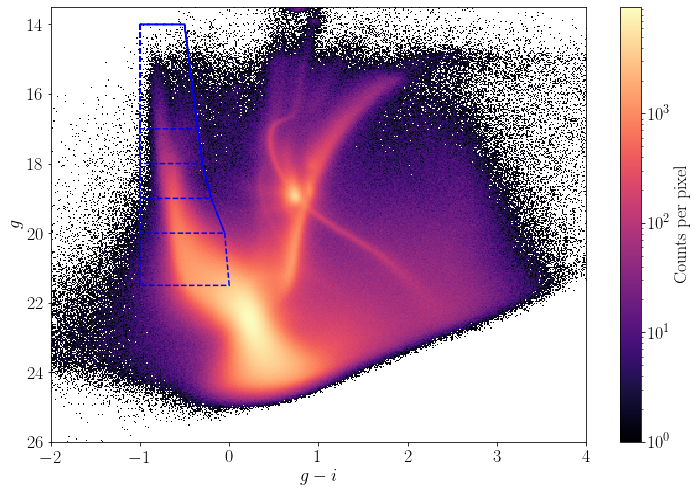

In [25]:
young1 = [(-1,14),(-1,17),(-0.35,17),(-0.5,14),(-1,14)]
young2 = [(-1,14),(-1,18),(-0.3,18),(-0.35,17),(-0.5,14),(-1,14)]
young3 = [(-1,14),(-1,19),(-0.2,19),(-0.3,18),(-0.35,17),(-0.5,14),(-1,14)]
young4 = [(-1,14),(-1,20),(-0.05,20),(-0.2,19),(-0.3,18),(-0.35,17),(-0.5,14),(-1,14)]
young5 = [(-1,14),(-1,21.5),(0.0,21.5),(-0.05,20),(-0.2,19),(-0.3,18),(-0.35,17),(-0.5,14),(-1,14)]
young_vertexs_list = [young1, young2, young3, young4, young5]

CMD_zone_plot(colour, i_mag, 72, young_vertexs_list)

In [26]:
cmd_points = np.array([colour, i_mag])
young_mask_list = [None]*len(young_vertexs_list)
for i, vertexs in enumerate(young_vertexs_list):
    #print(i)
    young_path = Path(vertexs)
    young_mask_list[i] = young_path.contains_points(cmd_points.T)


In [10]:
SMC_centre = SkyCoord.from_name('SMC')

In [27]:
power = 13
pixlist = hp.ang2pix(2**power, full_data['RA'][young_mask_list[4]], full_data['DEC'][young_mask_list[4]], lonlat=True)
pixels, counts = np.unique(pixlist, return_counts=True)
hpxmap = np.zeros(hp.nside2npix(2**power), dtype=np.int8)
for i, num in zip(pixels, counts):
    hpxmap[i] = num

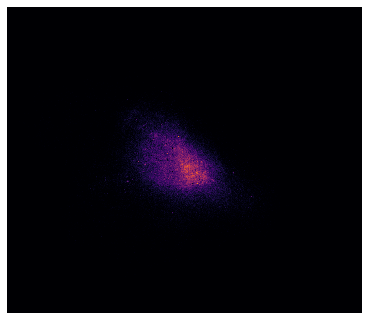

In [30]:
xsize = 1450
ysize = 1250
array_map = hp.gnomview(hpxmap, reso=hp.nside2resol(2**power, arcmin=True), notext=True, title='', cmap='inferno', xsize=xsize, ysize=ysize, min = 1, rot=(SMC_centre.ra.deg, SMC_centre.dec.deg, 0), coord='C', return_projected_map=True, cbar=False)


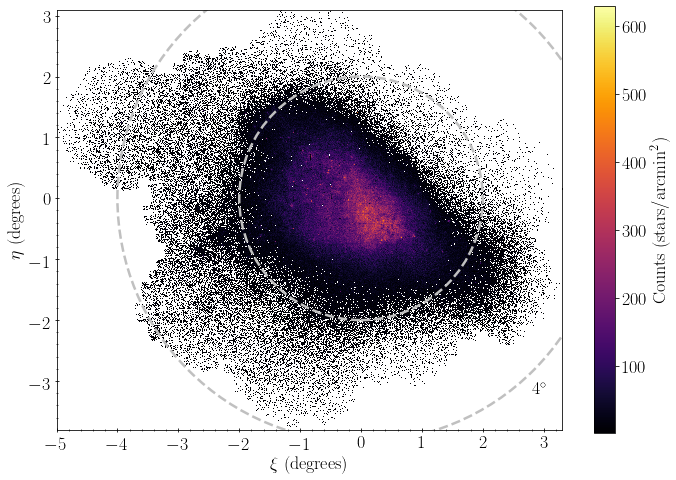

In [31]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size':18})

fig = plt.figure(1,figsize=(10,7))
ax = fig.add_subplot(111)

scale = hp.nside2resol(2**power, arcmin=True)/60.
top = -(scale) * (ysize/2.)
bottom =  (scale) * (ysize/2.)
left = -(scale) * (xsize/2.)
right = (scale) * (xsize/2.)

factor = 1./hp.nside2resol(2**power, arcmin=True)**2

mappable = ax.imshow(array_map*factor, origin='lower', cmap='inferno', extent=[left, right, top, bottom], vmin = 1)
#ax.grid(True, zorder=2)
cb = plt.colorbar(mappable, label = 'Counts (stars/arcmin$^{2}$)')

circle_2 = patches.Circle((0,0), radius=2, fill=False, ls='--', ec='silver', lw=2.5)
ax.add_patch(circle_2)
circle_4 = patches.Circle((0,0), radius=4, fill=False, ls='--', ec='silver', lw=2.5)
ax.add_patch(circle_4)

ax.annotate('2$^{\circ}$', (1.8,-1.2))
ax.annotate('4$^{\circ}$', (2.8,-3.2))

ax.set_xlabel(r'$\xi$ (degrees)')
ax.set_ylabel(r'$\eta$ (degrees)')
ax.set_xlim(-5,3.3)
ax.set_ylim(-3.8, 3.1)
ax.minorticks_on()
ax.tick_params(which='both', direction='inout')

fig.tight_layout()
#fig.savefig('/user/HS128/pm00518/Documents/PhD/SMC_SFH/Plots/density_map_young5.pdf')